In [1]:
import sys
sys.path.append('..')

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as mpatches

from scipy.stats import entropy
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.feature_selection import f_regression

from trickster.wfp_helper import load_data, extract

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

matplotlib.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

sns.set_context('paper', font_scale=2.5)

In [8]:
epsilons = [3, 4, 5]
results_pickle_names = ['../out/results_eps_{}_tracelen_500.pkl'.format(eps) for eps in epsilons]
adv_results = [pickle.load(open(filename, 'rb')) for filename in results_pickle_names]

## Runtime and success rates

In [53]:
expanded_df = pd.DataFrame(columns=['eps', 'nodes'])

for eps, results_df in zip(epsilons, adv_results):
    for i, row in results_df.iterrows():
        if row.found:
            expanded_df = expanded_df.append(
                {'eps': eps, 'nodes': float(row.nodes_expanded)},
                ignore_index=True)

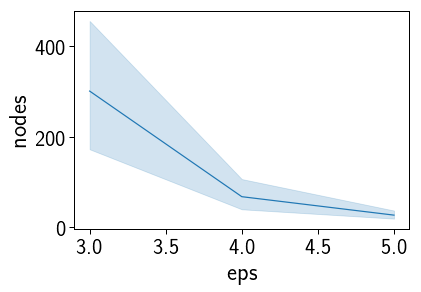

In [55]:
fig, ax = plt.subplots()

sns.lineplot(x='eps', y='nodes', data=expanded_df, ax=ax)

In [54]:
success_rates = [results_df.found.mean() for results_df in adv_results]

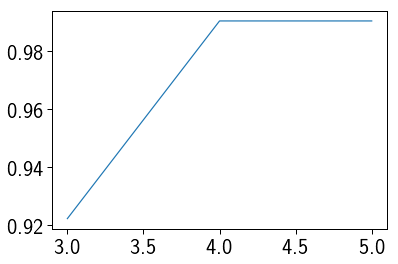

In [52]:
plt.plot(epsilons, success_rates)

## Cost overhead

In [80]:
costs_df = pd.DataFrame(columns=['eps', 'overhead'])

baseline_df = adv_results[0]

for eps, results_df in zip(epsilons, adv_results):
    for i, row in results_df.iterrows():
        if row.found:
            _, baseline_item = next(baseline_df[baseline_df['index']==row['index']].iterrows())
            if baseline_item.found:
                overhead = row.path_cost / baseline_item['path_cost']
                costs_df = costs_df.append({'eps': eps, 'overhead': overhead},
                                          ignore_index=True)

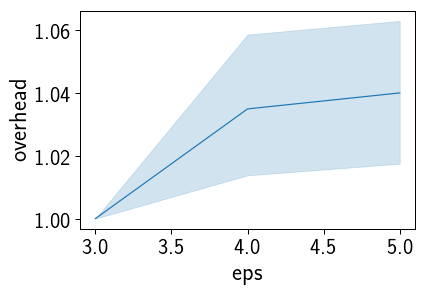

In [83]:
sns.lineplot(x='eps', y='overhead', data=costs_df)